In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [3]:
google = yf.download('GOOGL',
            start="2012-01-01",
            end="2021-12-31",
            progress=False)
google.head()

/tmp/ipython-input-3432578868.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  google = yf.download('GOOGL',


Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2012-01-03,16.537838,16.605937,16.213749,16.227914,146912940
2012-01-04,16.609171,16.658132,16.418792,16.528395,114445440
2012-01-05,16.378777,16.502051,16.309684,16.456321,131184684
2012-01-06,16.155340,16.403380,16.149623,16.382253,107608284
2012-01-09,15.470377,16.080284,15.439807,16.067858,232671096


In [6]:
df = google[ ["Open", "Close", "High", "Low"]].round(3)
df.head(10)

Price,Open,Close,High,Low
Ticker,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,
2012-01-03,16.228,16.538,16.606,16.214
2012-01-04,16.528,16.609,16.658,16.419
2012-01-05,16.456,16.379,16.502,16.310
2012-01-06,16.382,16.155,16.403,16.150
2012-01-09,16.068,15.470,16.080,15.440
2012-01-10,15.652,15.487,15.752,15.332
2012-01-11,15.496,15.557,15.643,15.437
2012-01-12,15.688,15.649,15.730,15.571


In [14]:
def ts_data(df, X_steps, y_steps):
  train_df = df.Close[:"2020"].values.reshape(-1, 1)
  test_df = df.Close["2021":].values.reshape(-1, 1)

  sc = MinMaxScaler(feature_range=(0, 1))
  train_df_scaled = sc.fit_transform(train_df)

  X_train = []
  y_train = []
  for i in range(X_steps, len(train_df_scaled)-y_steps+1):
    X_train.append(train_df_scaled[i-X_steps:i, 0])
    y_train.append(train_df_scaled[i:i+y_steps, 0])
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

  X = df.Close.values
  X = X[len(X)-len(test_df)-X_steps:]
  X = X.reshape(-1, 1)
  X = sc.transform(X)

  X_test = []
  y_test = []
  for i in range(X_steps, len(test_df)+X_steps-y_steps+1):
    X_test.append(X[i-X_steps:i, 0])
    y_test.append(X[i:i+y_steps, 0])

  X_test = np.array(X_test)
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
  y_test = np.array(y_test)

  return X_train, y_train, X_test, y_test, sc

In [24]:
def prediction_plot(predictions):
  fig, ax = plt.subplots()
  ax.plot(df["2021":].index[:len(y_test)],
          sc.inverse_transform(y_test[:, 0].reshape(-1, 1)), label="Real")
  ax.plot(df["2021":].index[:len(y_test)],
          sc.inverse_transform(predictions[:, 0].reshape(-1, 1)), label="Prediction")

In [15]:
X_train, y_train, X_test, y_test, sc = ts_data(df, 10, 4)

In [16]:
X_train.shape

(2252, 10, 1)

In [17]:
y_train.shape

(2252, 4)

In [21]:
simple_rnn_model = keras.models.Sequential([
    layers.SimpleRNN(50,return_sequences=True),
    layers.SimpleRNN(50,return_sequences=True),
    layers.SimpleRNN(50,return_sequences=True),
    layers.SimpleRNN(50),
    layers.Dense(4)
])

In [22]:
simple_rnn_model.compile(optimizer="nadam", loss="mean_squared_error")

In [23]:
simple_rnn_model.fit(X_train, y_train, epochs=100, validation_split=0.15)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0832 - val_loss: 0.0180
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.5607e-04 - val_loss: 0.0120
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0104
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9960e-04 - val_loss: 0.0138
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0068
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3945e-04 - val_loss: 0.0075
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 0.0139
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4469e-04 - val_loss: 0.0124
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1801e-04 - val_loss: 0.0072
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0550e-04 - val_loss: 0.0078
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8874e-04 - val_loss: 0.0096
Epoch 12/100
60/60 ━━━━━━━━━━━━━━

In [25]:
simple_rnn_pred = simple_rnn_model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step


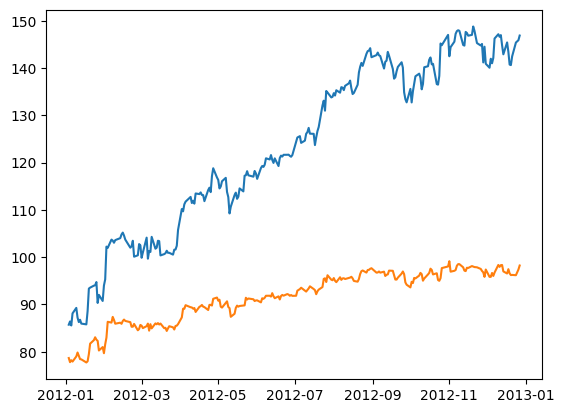

In [26]:
prediction_plot(simple_rnn_pred)

In [27]:
lstm_model = keras.models.Sequential([
    layers.LSTM(50,return_sequences=True),
    layers.LSTM(50,return_sequences=True),
    layers.LSTM(50,return_sequences=True),
    layers.LSTM(50),
    layers.Dense(4)
])

In [28]:
lstm_model.compile(optimizer="nadam", loss="mean_squared_error")

In [29]:
lstm_model.fit(X_train, y_train, epochs=100, validation_split=0.15)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0445 - val_loss: 0.0025
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3865e-04 - val_loss: 0.0037
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.7329e-04 - val_loss: 0.0088
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.0352e-04 - val_loss: 0.0066
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.9527e-04 - val_loss: 0.0056
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5136e-04 - val_loss: 0.0071
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8729e-04 - val_loss: 0.0050
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.7441e-04 - val_loss: 0.0054
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.9668e-04 - val_loss: 0.0085
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.6222e-04 - val_loss: 0.0065
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9274e-04 - val_loss: 0.0063
Epoch 12/100

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


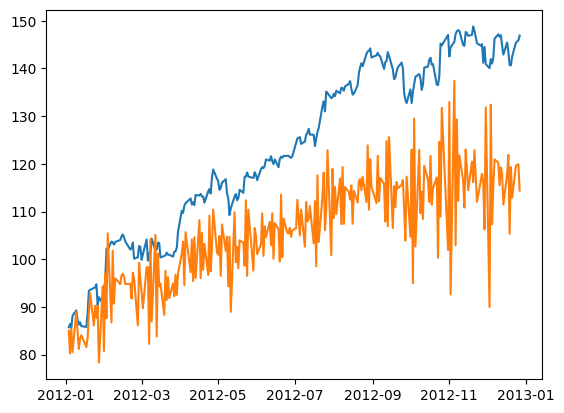

In [30]:
prediction_plot(lstm_model.predict(X_test))

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0296 - val_loss: 0.0019
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8842e-04 - val_loss: 0.0024
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.0188e-04 - val_loss: 0.0021
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1819e-04 - val_loss: 0.0021
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1279e-04 - val_loss: 0.0017
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2531e-04 - val_loss: 0.0015
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9024e-04 - val_loss: 0.0016
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6428e-04 - val_loss: 0.0028
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8775e-04 - val_loss: 0.0023
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7222e-04 - val_loss: 0.0025
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.7345e-04 - val_loss: 0.0015
Epoch 12/100

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


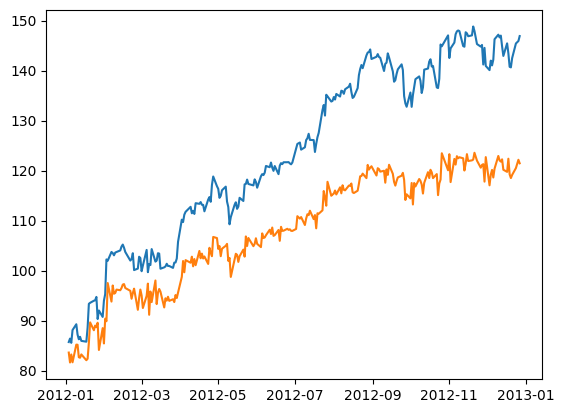

In [31]:
gru_model = keras.models.Sequential([
    layers.GRU(50,return_sequences=True),
    layers.GRU(50,return_sequences=True),
    layers.GRU(50,return_sequences=True),
    layers.GRU(50),
    layers.Dense(4)
])
gru_model.compile(optimizer="nadam", loss="mean_squared_error")
gru_model.fit(X_train, y_train, epochs=100, validation_split=0.15)
prediction_plot(gru_model.predict(X_test))